# Damping and Spring constant identification using Tracker

Team 3

## Setup

In [1]:
pip install pynamics

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import scipy.optimize
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
import pynamics.integration
import numpy
import sympy
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
plt.ion()
from math import pi, sin, cos, tan, asin, acos, atan, degrees, radians, pi

## Procedure

In [4]:
import logging
import pynamics.integration
import pynamics.system
import numpy.random
import scipy.interpolate
import scipy.optimize
import pandas as pd
import cma

In [5]:
# Create a pynamics system
system = System()
pynamics.set_system(__name__,system)

In [6]:
# Length variables (numerical)
lA_num = 0.15
lB_num = 0.15
lC_num = 0.165
lD_num = 0.165
lE_num = 0.045

# Lengths
lA = Constant(lA_num,'lA',system)
lB = Constant(lB_num,'lB',system)
lC = Constant(lC_num,'lC',system)
lD = Constant(lD_num,'lD',system)
lE = Constant(lE_num,'lE',system)

In [7]:
# Masses
mA = Constant(0.027,'mA',system)
mB = Constant(0.0306,'mB',system)
mC = Constant(0.0297,'mC',system)
mD = Constant(0.0297,'mD',system)

# Joint preloads
preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(0*pi/180,'preload2',system)
preload3 = Constant(0*pi/180,'preload3',system)
preload4 = Constant(0*pi/180,'preload4',system)

# Inertia
Ixx_A = Constant(0.000202,'Ixx_A',system) #0.00020264
Iyy_A = Constant(0.000405,'Iyy_A',system) #(0.00040500
Izz_A = Constant(0.000202,'Izz_A',system) #0.00020264
Ixx_B = Constant(0.000223,'Ixx_B',system) #0.00022378
Iyy_B = Constant(0.000427,'Iyy_B',system) #0.00042744
Izz_B = Constant(0.000204,'Izz_B',system) #0.00020422
Ixx_C = Constant(0.000222,'Ixx_C',system) #0.00022291
Iyy_C = Constant(0.000492,'Iyy_C',system) #0.00049228
Izz_C = Constant(0.000269,'Izz_C',system) #0.00026969
Ixx_D = Constant(0.000222,'Ixx_D',system) #0.00022291
Iyy_D = Constant(0.000492,'Iyy_D',system) #0.00049228
Izz_D = Constant(0.000269,'Izz_D',system) #0.00026969

In [8]:
tol = 1e-12

tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [9]:
# Create differentiable state variables
qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)
qD,qD_d,qD_dd = Differentiable('qD',system)

In [10]:
# initial values
# qC = 11.97 creates fully extended, horizontal wing
initialvalues = {}
initialvalues[qA]=45*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=0*pi/180
initialvalues[qB_d]=0*pi/180

#initialvalues[qC]=14.65*pi/180
initialvalues[qC]=(-90)*pi/180
initialvalues[qC_d]=0*pi/180
initialvalues[qD]=-15*pi/180
initialvalues[qD_d]=0*pi/180

In [11]:
# Retrieve state variables in the order they are stored in the system
# Create a list of initial values ini0 in the order of the system’s state variables
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

In [12]:
# Create frames
N = Frame('N')
A = Frame('A')
B = Frame('B')
C = Frame('C')
D = Frame('D')

In [13]:
# Declare N as the Newtonian (fixed) frame
system.set_newtonian(N)

In [14]:
# Rotate other frames about their local Z axes.
# Not global q
A.rotate_fixed_axis_directed(N,[0,0,1],qA,system)
B.rotate_fixed_axis_directed(A,[0,0,1],qB,system)
C.rotate_fixed_axis_directed(N,[0,0,1],qC,system)
D.rotate_fixed_axis_directed(C,[0,0,1],qD,system)

In [15]:
# Define rigid body kinematics
# position vectors
p0 = 0*N.y #Normal
p1 = p0 + lA*-A.y #Link A
p2A = p1 + lB*-B.y #Link B - OUTPUT
p4 = p0 + lE*-N.x #Link E
p3 = p4 + lC*-C.y #Link C
p2C = p3 + lD*-D.y #Link D - OUTPUT

In [16]:
# CoM vectors
pAcom=p0 + lA/2*A.x #Link A
pBcom=p1 + 0.06735294*B.x #Link B
pCcom=p4 + lC/2*C.x #Link C
pDcom=p3 + lD/2*D.x #Link D

In [17]:
# Angular Velocity
wNA = N.getw_(A)
wAB = A.getw_(B)
wNC = N.getw_(C)
wCD = C.getw_(D)

In [18]:
# Build inertia tensors
IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)
ID = Dyadic.build(D,Ixx_D,Iyy_D,Izz_D)

BodyA = Body('BodyA',A,pAcom,mA,IA,system)
BodyB = Body('BodyB',B,pBcom,mB,IB,system)
BodyC = Body('BodyC',C,pCcom,mC,IC,system)
BodyD = Body('BodyD',D,pDcom,mD,ID,system)
#BodyC = Particle(pCcm,mC,'ParticleC',system)

## Forces

In [19]:
b1 = Constant(1e1,'b1',system)
b2 = Constant(1e1,'b2',system)
b3 = Constant(1e1,'b3',system)
b4 = Constant(1e1,'b4',system)

In [20]:
# Forces
system.addforce(-b1*wNA,wNA)
system.addforce(-b2*wAB,wAB)
system.addforce(-b3*wNC,wNC)
system.addforce(-b4*wCD,wCD)

In [24]:
k1 = Constant(1e1,'k1',system)
k2 = Constant(1e1,'k2',system)
k3 = Constant(1e1,'k3',system)
k4 = Constant(1e1,'k4',system)

In [25]:
# Spring Forces
# Not global q
system.add_spring_force1(k1,(qA-preload1)*N.z,wNA) 
system.add_spring_force1(k2,(qB-preload2)*A.z,wAB)
system.add_spring_force1(k3,(qC-preload3)*N.z,wNC)
system.add_spring_force1(k4,(qD-preload4)*C.z,wCD)

(<pynamics.force.Force at 0x263b1f81848>,
 <pynamics.spring.Spring at 0x263b1de90c8>)

In [26]:
# gravity
g = Constant(9.81,'g',system)

In [27]:
# Gravity
system.addforcegravity(-g*N.y)

## Constraints

In [28]:
# Constraints
eq_vector = p2A-p2C
eq = []
eq.append((eq_vector).dot(N.x))
eq.append((eq_vector).dot(N.y))
eq_d=[(system.derivative(item)) for item in eq]
eq_dd=[(system.derivative(item)) for item in eq_d]

#eq2_vector = A.x-B.x
#eq2 = []
#eq2.append((eq2_vector).dot(N.x))
#eq2.append((eq2_vector).dot(N.y))
#eq2_d=[(system.derivative(item)) for item in eq2]
#eq2_dd=[(system.derivative(item)) for item in eq2_d]

In [29]:
f,ma=system.getdynamics()

2021-03-19 16:37:38,647 - pynamics.system - INFO - getting dynamic equations


## Modifications

In [30]:
unknown_constants = [b1,b2,b3,b4,k1,k2,k3,k4]

In [31]:
known_constants = list(set(system.constant_values.keys())-set(unknown_constants))
known_constants = dict([(key,system.constant_values[key]) for key in known_constants])
known_constants

{Ixx_A: 0.000202, Ixx_B: 0.000223, Ixx_C: 0.000222, Ixx_D: 0.000222, Iyy_A: 0.
000405, Iyy_B: 0.000427, Iyy_C: 0.000492, Iyy_D: 0.000492, Izz_A: 0.000202, Iz
z_B: 0.000204, Izz_C: 0.000269, Izz_D: 0.000269, g: 9.81, lA: 0.15, lB: 0.15, 
lC: 0.165, lD: 0.165, lE: 0.045, mA: 0.027, mB: 0.0306, mC: 0.0297, mD: 0.0297
, preload₁: 0.0, preload₂: 0.0, preload₃: 0.0, preload₄: 0.0}

In [32]:
func1,lambda1 = system.state_space_post_invert(f,ma,eq_dd,return_lambda = True,constants = known_constants)

2021-03-19 16:37:56,630 - pynamics.system - INFO - solving a = f/m and creating function
2021-03-19 16:37:58,108 - pynamics.system - INFO - substituting constrained in Ma-f.
2021-03-19 16:37:58,536 - pynamics.system - INFO - done solving a = f/m and creating function
2021-03-19 16:37:58,538 - pynamics.system - INFO - calculating function for lambdas


In [33]:
def run_sim(args):
    constants = dict([(key,value) for key,value in zip(unknown_constants,args)])
    states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol,hmin=tol, args=({'constants':constants},))
    return states

In [34]:
points = [p2A,p1,p3]

In [35]:
points_output=PointsOutput(points,system)

## Loading Data

In [36]:

df=pd.read_csv(r'E:\OneDrive - Arizona State University\Spring 2021\EGR 557 Foldable Robotics\TrackerVideos\WingTipfinal.txt', sep=',')
df1=pd.read_csv(r'E:\OneDrive - Arizona State University\Spring 2021\EGR 557 Foldable Robotics\TrackerVideos\BottomJointfinal.txt', sep=',')
df2=pd.read_csv(r'E:\OneDrive - Arizona State University\Spring 2021\EGR 557 Foldable Robotics\TrackerVideos\TopJointfinal.txt', sep=',')
x = df.x.to_numpy()
y = df.y.to_numpy()
t = df.t.to_numpy()
x2 = df1.x.to_numpy()
y2 = df1.y.to_numpy()
t2 = df1.t.to_numpy()
x3 = df2.x.to_numpy()
y3 = df2.y.to_numpy()
t3 = df2.t.to_numpy()
xy = numpy.array([x,y,x2,y2,x3,y3]).T

In [37]:
fy = scipy.interpolate.interp1d(t,xy.T,fill_value='extrapolate')
fyt = fy(t).T
fyt.shape

(3336, 6)

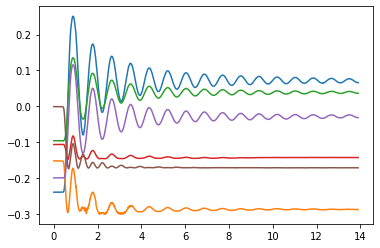

In [38]:
plt.figure()
plt.plot(t,fyt)

In [40]:
def calc_error(args):
    states_guess = run_sim(args)
    y_guess = points_output.calc(states_guess)
    y_guess = y_guess.reshape((3336,-1))
    error = fyt - y_guess
    error **=2
    error = error.sum()
    return error    

In [41]:
pynamics.system.logger.setLevel(logging.ERROR)

In [42]:
k_guess = [1e1,1e1,1e1,1e1,1e1,1e1,1e1,1e1]

In [54]:
#method = None
method = 'CMA'
#method = 'BFGS'

if method is None:
    result = k_guess
elif method == 'CMA':
    es = cma.CMAEvolutionStrategy(k_guess, 0.5)
    es.logger.disp_header()
    while not es.stop():
          X = es.ask()
          es.tell(X, [calc_error(x) for x in X])
          es.logger.add()
          es.logger.disp([-1])
    result = es.best.x
else:
    sol = scipy.optimize.minimize(calc_error,k_guess,method = method)
    print(sol.fun)
    result = sol.x

2021-03-18 11:17:18,006 - pynamics.integration - INFO - beginning integration
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=142807, Thu Mar 18 11:17:18 2021)
Iterat Nfevals  function value    axis ratio maxstd  minstd
2021-03-18 11:33:17,051 - pynamics.integration - INFO - finished integration
2021-03-18 11:33:17,054 - pynamics.output - INFO - calculating outputs
2021-03-18 11:33:17,200 - pynamics.output - INFO - done calculating outputs
2021-03-18 11:33:18,915 - pynamics.integration - INFO - beginning integration
2021-03-18 11:50:12,442 - pynamics.integration - INFO - finished integration
2021-03-18 11:50:12,445 - pynamics.output - INFO - calculating outputs
2021-03-18 11:50:12,630 - pynamics.output - INFO - done calculating outputs
2021-03-18 11:50:12,633 - pynamics.integration - INFO - beginning integration
2021-03-18 12:11:54,361 - pynamics.integration - INFO - finished integration
2021-03-18 12:11:54,366 - pynamics.output - INFO - calculating outputs
2021-03-18 12:11:54,

KeyboardInterrupt: 

In [50]:
y_guess

NameError: name 'y_guess' is not defined